<mark>**Seen Population for FT**</mark>  : We used the ABCS file for part-time students from sitelink : https://www.officeforstudents.org.uk/data-and-analysis/associations-between-characteristics-of-students/progressing-from-part-time-higher-education/   to map the characteristics of each student. We obtained the predicted outcome rate and quintiles attached to each student, then quantified how close the predictions were to the actual historical progression outcome flag. This process involves setting a threshold for the predicted outcome rate to classify students as positive or negative, as historical progression is binary (positive/negative)

<mark>**Importing Libraries**</mark>

In [1]:
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import pandas as pd
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import MapType, StringType
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 3, Finished, Available, Finished)

<mark>**pt ofs data**</mark>

In [2]:
df_p = spark.sql("SELECT * FROM SilverData.external_progression_data")
df_ft=df_p.toPandas()
df_ft

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 4, Finished, Available, Finished)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,-- Any quintile --,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,-- Any quintile --,-- Any quintile --,Local,Female,0.620000,1,2024-11-25 08:59:18.184056
1,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - African,-- Any quintile --,-- Any quintile --,Local,Female,0.730000,1,2024-11-25 08:59:18.184056
2,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,-- Any quintile --,-- Any quintile --,Local,Female,0.670000,1,2024-11-25 08:59:18.184056
3,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
4,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770852,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770853,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770854,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770855,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056


<mark>**Mapping Any categories as blanks and Local as FT and Distance as PT**</mark>

In [3]:
df_ft1 = df_ft.replace({
    '-- Any quintile --':'', 
    '-- Any disability --':'', 
    '-- Any ethnicity --':'', 
    '-- Any quintile --':'', 
    '-- Any learner --': '',
    '-- Any sex --': '',
    'Local':'FT',
    'Distance':'PT',
    '-- Any age group --':''  
})

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 5, Finished, Available, Finished)

<mark>**Filtering FT combinations only**</mark>

In [4]:
df_ft1= df_ft1[df_ft1['Local_or_distance_learner']=='FT']
df_ft1

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 6, Finished, Available, Finished)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,,,FT,Female,0.620000,1,2024-11-25 08:59:18.184056
1,,21-25,Cognitive or learning difficulties,Black or black British - African,,,FT,Female,0.730000,1,2024-11-25 08:59:18.184056
2,,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,,,FT,Female,0.670000,1,2024-11-25 08:59:18.184056
3,,21-25,Cognitive or learning difficulties,Mixed - other,,,FT,Female,0.740000,1,2024-11-25 08:59:18.184056
4,,21-25,Cognitive or learning difficulties,Mixed - other,,,FT,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770837,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770838,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770839,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770840,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056


In [5]:
df_ft1.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 7, Finished, Available, Finished)

Adult_HE_quintile                6
Age_group                        9
Disability                       7
Ethnicity                       15
IDACI                            6
IMD                              6
Local_or_distance_learner        1
Sex                              3
Predicted_outcome_rate          77
Derived_progression_quintile     5
createdAt                        1
dtype: int64

<mark>**Checking all the unique categories**</mark>

In [6]:
df_ft1['Disability'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 8, Finished, Available, Finished)

array(['Cognitive or learning difficulties',
       'Sensory, medical or physical impairments',
       'Multiple or other impairments',
       'Social or communication impairment', 'Mental health condition',
       '', 'No disability reported'], dtype=object)

In [7]:
df_ft1['Adult_HE_quintile'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 9, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4',
       'Quintile 5'], dtype=object)

In [8]:
df_ft1['IDACI'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 10, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 4', 'Quintile 3',
       'Quintile 5'], dtype=object)

In [9]:
df_ft1['Age_group'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 11, Finished, Available, Finished)

array(['21-25', '31-40', '26-30', '41-50', '51+', '', '19', '20',
       '18 and under'], dtype=object)

In [10]:
df_ft1['IMD'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 12, Finished, Available, Finished)

array(['', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4',
       'Quintile 5'], dtype=object)

In [11]:
df_ft1['Ethnicity'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 13, Finished, Available, Finished)

array(['Asian or Asian British - Pakistani',
       'Black or black British - African',
       'Black or black British - Caribbean', 'Mixed - other',
       'Other ethnic group', '', 'White',
       'Asian or Asian British - Indian',
       'Asian or Asian British - other', 'Black or black British - other',
       'Mixed - white and black African',
       'Asian or Asian British - Bangladeshi',
       'Mixed - white and black Caribbean', 'Refused or unknown',
       'Mixed - white and Asian'], dtype=object)

In [12]:
df_ft1['Sex'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 14, Finished, Available, Finished)

array(['Female', '', 'Male'], dtype=object)

In [13]:
# df_ft1.dtypes

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 15, Finished, Available, Finished)

<mark>**Creating Concatenated column by adding all the characteristics**</mark>

In [14]:
# Concatenate columns by converting all values to strings
df_ft1['Concatenated_column'] = (
    df_ft1['Adult_HE_quintile'].astype(str) + 
    df_ft1['Age_group'].astype(str) + 
    df_ft1['Disability'].astype(str) + 
    df_ft1['Ethnicity'].astype(str) + 
    df_ft1['IDACI'].astype(str) + 
    df_ft1['IMD'].astype(str) + 
    df_ft1['Local_or_distance_learner'].astype(str) + 
    df_ft1['Sex'].astype(str)
)


StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 16, Finished, Available, Finished)

In [15]:
df_ft1=df_ft1[['Predicted_outcome_rate','Derived_progression_quintile','Concatenated_column']]

df_ft1

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 17, Finished, Available, Finished)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column
0,0.620000,1,21-25Cognitive or learning difficultiesAsian o...
1,0.730000,1,21-25Cognitive or learning difficultiesBlack o...
2,0.670000,1,21-25Cognitive or learning difficultiesBlack o...
3,0.740000,1,21-25Cognitive or learning difficultiesMixed -...
4,0.740000,1,21-25Cognitive or learning difficultiesMixed -...
...,...,...,...
770837,0.820000,3,No disability reportedMixed - white and black ...
770838,0.820000,3,No disability reportedMixed - white and black ...
770839,0.820000,3,No disability reportedMixed - white and black ...
770840,0.820000,3,No disability reportedMixed - white and black ...


<mark>**characteristics table**</mark>

In [16]:
df_char = spark.sql("SELECT * FROM SilverData.event_student_characteristics")
df_characteristics=df_char.toPandas()
df_characteristics=df_characteristics.rename(columns={'stunumber':'StudentNumber'}, inplace=False)
# Remove columns that end with 'value'
df_characteristics = df_characteristics[[col for col in df_characteristics.columns if not col.endswith('value')]]
df_characteristics=df_characteristics.drop(columns=['student_id','created_at','modified_at'])
df_characteristics

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 18, Finished, Available, Finished)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,idaci_desc,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc
0,STU223216,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Heterosexual,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
1,STU233638,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Other_Sexual_Orientation,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
2,STU232679,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
3,STU226091,21 to 25 years on entry,Refused_or_Unknown,Female,Refused_unknown_or_not_collected,Information refused,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
4,STU226874,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,No,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96210,STU113403,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Higher National Diploma (HND)
96211,STU146681,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
96212,STU152040,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,UK first degree with honours
96213,STU129002,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level C


In [17]:
df_characteristics.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 19, Finished, Available, Finished)

StudentNumber                  96215
age_on_entry                       7
ethnicity_16_groups               15
sex                                4
ethnicity_6_groups                 6
gender_identity                    4
tundra_msoa_quintile_desc          6
adult_he_2011_quintile_desc        6
polar4_quintile_desc               6
imd_desc                           6
idaci_desc                         6
religion_or_belief                 9
sexual_orientation                 4
parental_education                 4
disability_type                    6
disability_status                  2
care_leaver                        2
entry_qualification_desc          55
dtype: int64

<mark>**Checking unique categories of our Arden characteristics**</mark>

In [18]:
df_characteristics['disability_type'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 20, Finished, Available, Finished)

array(['No_disability_reported_or_unknown', 'Mental_health_condition',
       'Sensory_medical_or_physical_impairment',
       'Cognitive_or_learning_difficulties',
       'Multiple_or_other_impairments',
       'Social_or_communication_impairment'], dtype=object)

In [19]:
df_characteristics['sex'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 21, Finished, Available, Finished)

array(['Male', 'Female', 'Refused_unknown_or_not_collected', 'Other_sex'],
      dtype=object)

In [20]:
df_characteristics['adult_he_2011_quintile_desc'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 22, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3', 'Quintile 5',
       'Quintile 2', 'Quintile 4', 'Quintile 1'], dtype=object)

In [21]:
df_characteristics['idaci_desc'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 23, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3', 'Quintile 4',
       'Quintile 2', 'Quintile 1', 'Quintile 5'], dtype=object)

In [22]:
df_characteristics['imd_desc'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 24, Finished, Available, Finished)

array(['Unknown or invalid home postcode', 'Quintile 3 England',
       'Quintile 4 England', 'Quintile 2 England', 'Quintile 5 England',
       'Quintile 1 England'], dtype=object)

In [23]:
df_characteristics['ethnicity_16_groups'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 25, Finished, Available, Finished)

array(['Refused_or_Unknown', 'White',
       'Asian_or_Asian_British_Bangladeshi', 'Gypsy_or_Traveller',
       'Asian_or_Asian_British_Pakistani', 'Asian_or_Asian_British_other',
       'Mixed_other', 'Black_or_black_British_Caribbean',
       'Other_ethnic_group', 'Asian_or_Asian_British_Indian',
       'Black_or_black_British_African', 'Asian_or_Asian_British_Chinese',
       'Mixed_White_and_Asian', 'Mixed_White_and_black_Caribbean',
       'Mixed_White_and_black_African'], dtype=object)

In [24]:
df_characteristics['age_on_entry'].unique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 26, Finished, Available, Finished)

array(['Under 21 years on entry', '21 to 25 years on entry',
       '41 to 50 years on entry', '31 to 40 years on entry',
       '26 to 30 years on entry', '51 years and over on entry', 'Unknown'],
      dtype=object)

<mark>**Assigning similar categories for easier mapping**</mark>

In [25]:
df_characteristics = df_characteristics.replace({
    '51 years and over on entry':'51+', #
    '41 to 50 years on entry':'41-50', #
    '26 to 30 years on entry':'26-30', #
    'Under 21 years on entry':'20', #
    '21 to 25 years on entry': '21-25', #
    '31 to 40 years on entry': '31-40', #
    'Unknown':'',#age

    'Refused_or_Unknown':'Refused or unknown',# ethn
    
    # 'Refused_unknown_or_not_collected':'Refused or unknown',
    'White':'White',
    'Black_or_black_British_African':'Black or black British - African',
    'Other_ethnic_group':'Other ethnic group', 
    'Mixed_other':'Mixed - other',
    'Gypsy_or_Traveller':'',
    'Black_or_black_British_Caribbean':'Black or black British - Caribbean',
    'Asian_or_Asian_British_Bangladeshi':'Asian or Asian British - Bangladeshi',
    'Asian_or_Asian_British_Pakistani':'Asian or Asian British - Pakistani',
    'Mixed_White_and_black_African':'Mixed - white and black African',
    'Mixed_White_and_black_Caribbean':'Mixed - white and black Caribbean',
    'Asian_or_Asian_British_other':'Asian or Asian British - other', 
    'Asian_or_Asian_British_Chinese':'Asian or Asian British - Chinese',
    'Mixed_White_and_Asian':'Mixed - white and Asian', 
    'Asian_or_Asian_British_Indian':'Asian or Asian British - Indian',
    
    'Refused_unknown_or_not_collected':'',#sex
    'Other_sex':'',#sex

    'Unknown or invalid home postcode':'',
    'Quintile 1 England':'Quintile 1', 
    'Quintile 3 England':'Quintile 3', 
    'Quintile 2 England':'Quintile 2',
    'Quintile 4 England':'Quintile 4', 
    'Quintile 5 England':'Quintile 5',

    # 'Not_known':'',
    # 'Prefer_not_to_say':'',

    'No_disability_reported_or_unknown':'No disability reported', 
    'Mental_health_condition':'Mental health condition',
    'Cognitive_or_learning_difficulties':'Cognitive or learning difficulties',
    'Sensory_medical_or_physical_impairment':'Sensory, medical or physical impairments',
    'Multiple_or_other_impairments':'Multiple or other impairments',
    'Social_or_communication_impairment':'Social or communication impairment'
    
})


StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 27, Finished, Available, Finished)

In [26]:
df_characteristics.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 28, Finished, Available, Finished)

StudentNumber                  96215
age_on_entry                       7
ethnicity_16_groups               15
sex                                3
ethnicity_6_groups                 6
gender_identity                    4
tundra_msoa_quintile_desc          6
adult_he_2011_quintile_desc        6
polar4_quintile_desc               6
imd_desc                           6
idaci_desc                         6
religion_or_belief                 9
sexual_orientation                 4
parental_education                 4
disability_type                    6
disability_status                  2
care_leaver                        2
entry_qualification_desc          55
dtype: int64

<mark>**historical data**</mark>

In [27]:
df_study_mode = spark.sql("Select Student_Code,Event_Context,Event_Description from event_students where Event_Type = 'Progression Outcome'")
df_study_mode_pandas = df_study_mode.toPandas()
df_study_mode_pandas['Study Mode Details'] = df_study_mode_pandas['Event_Context']
df_study_mode_pandas = df_study_mode_pandas[['Student_Code', 'Study Mode Details','Event_Description']]
df_study_mode_pandas

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 29, Finished, Available, Finished)

,Student_Code,Study Mode Details,Event_Description
0,STU37252,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
1,STU64336,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
2,STU51841,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
3,STU58143,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
4,STU37792,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
...,...,...,...
1573,STU53397,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1574,STU58274,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Positive
1575,STU53864,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1576,STU53853,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative


<mark>**Fetching details like mode of study and level of study**</mark>

In [28]:
schema = MapType(StringType(), StringType())

df_spark_study_mode = spark.createDataFrame(df_study_mode_pandas)

df_spark_study_mode = df_spark_study_mode.withColumn("Study Mode Details", from_json(col("Study Mode Details"), schema))
df_spark_study_mode = df_spark_study_mode.withColumn("IPSTARTMODE", col("Study Mode Details").getItem("Ipstartmode"))
df_spark_study_mode = df_spark_study_mode.withColumn("IPLEVEL", col("Study Mode Details").getItem("Iplevel"))

df_spark_study_mode=df_spark_study_mode.drop("Study Mode Details")

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 30, Finished, Available, Finished)

In [29]:
df_progression_historical = df_spark_study_mode.toPandas()
df_progression_historical

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 31, Finished, Available, Finished)

,Student_Code,Event_Description,IPSTARTMODE,IPLEVEL
0,STU37252,Progression: Positive,PT,PGTM
1,STU64336,Progression: Positive,PT,PGTM
2,STU51841,Progression: Positive,PT,PGTM
3,STU58143,Progression: Positive,PT,PGTM
4,STU37792,Progression: Positive,PT,PGTM
...,...,...,...,...
1573,STU53397,Progression: Negative,FT,DEG
1574,STU58274,Progression: Positive,FT,DEG
1575,STU53864,Progression: Negative,FT,DEG
1576,STU53853,Progression: Negative,FT,DEG


<mark>**Fetching the actual progression flags for students**</mark>

In [30]:
df_progression_historical['Outcome'] = df_progression_historical['Event_Description'].str.split(': ').str[1]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 32, Finished, Available, Finished)

In [31]:
df_hist = df_progression_historical.drop('Event_Description', axis=1)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 33, Finished, Available, Finished)

In [32]:
df_hist.columns = ['StudentNumber', 'IPSTARTMODE', 'IPLEVEL', 'Outcome']

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 34, Finished, Available, Finished)

<mark>**Separating FT students and discarding Neutral Progression flags**</mark>

In [33]:
df_hist= df_hist[df_hist['IPSTARTMODE']=='FT']
df_hist= df_hist[df_hist['Outcome']!='Neutral']
# df_hist= df_hist[df_hist['Outcome']!='Partial']
# df_hist = df_hist.drop(columns=['IPCOMDATE','IPBASEYEAR','COURSEID','CourseTitle(Combined)'])
df_hist

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 35, Finished, Available, Finished)

,StudentNumber,IPSTARTMODE,IPLEVEL,Outcome
143,STU51724,FT,PGTM,Negative
421,STU70305,FT,DEG,Negative
422,STU62921,FT,DEG,Negative
423,STU64009,FT,DEG,Negative
424,STU46216,FT,DEG,Negative
...,...,...,...,...
1573,STU53397,FT,DEG,Negative
1574,STU58274,FT,DEG,Positive
1575,STU53864,FT,DEG,Negative
1576,STU53853,FT,DEG,Negative


In [34]:
df_hist.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 36, Finished, Available, Finished)

StudentNumber    741
IPSTARTMODE        1
IPLEVEL            2
Outcome            2
dtype: int64

<mark>**historical data +characteristics join on student number**</mark>

In [35]:
concat_hist_char = df_characteristics.merge(df_hist,on='StudentNumber', how='inner')
concat_hist_char = concat_hist_char.drop_duplicates()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 37, Finished, Available, Finished)

In [36]:
concat_hist_char

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 38, Finished, Available, Finished)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,...,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc,IPSTARTMODE,IPLEVEL,Outcome
0,STU69375,41-50,White,Male,White,Yes,Quintile 1,Quintile 2,Quintile 1,Quintile 1,...,Buddhist,Heterosexual,No,"Sensory, medical or physical impairments",Disability_Reported,Care_experienced,UK first degree with honours,FT,DEG,Negative
1,STU68962,41-50,White,Male,White,Not available,Quintile 5,Quintile 5,Quintile 4,Quintile 3,...,Any_other_religion_or_belief,Heterosexual,Not_known,Mental health condition,Disability_Reported,"Refused, unknown or not collected",Higher National Diploma (HND),FT,DEG,Negative
2,STU65338,31-40,White,Female,White,Yes,Quintile 3,Quintile 4,Quintile 4,Quintile 5,...,Any_other_religion_or_belief,Heterosexual,Yes,Mental health condition,Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,FT,DEG,Positive
3,STU62316,26-30,White,Female,White,Yes,Quintile 2,Quintile 1,Quintile 2,Quintile 2,...,Any_other_religion_or_belief,Lesbian_Gay_OR_Bisexual,No,Mental health condition,Disability_Reported,Care_experienced,Diploma at level 3,FT,DEG,Positive
4,STU56635,31-40,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 2,...,Any_other_religion_or_belief,Refused_Unknown_or_not_collected,No,Mental health condition,Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,FT,DEG,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,STU64519,20,White,Female,White,Yes,Quintile 3,Quintile 3,Quintile 3,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,A/AS level,FT,DEG,Positive
742,STU83875,41-50,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Higher National Diploma (HND),FT,DEG,Negative
743,STU66401,21-25,White,Female,White,Yes,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which none are subje...,FT,DEG,Positive
744,STU91604,31-40,White,Female,White,Yes,Quintile 5,Quintile 4,Quintile 5,Quintile 5,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Higher National Diploma (HND),FT,DEG,Positive


In [37]:
concat_hist_char.columns

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 39, Finished, Available, Finished)

Index(['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'ethnicity_6_groups', 'gender_identity', 'tundra_msoa_quintile_desc',
       'adult_he_2011_quintile_desc', 'polar4_quintile_desc', 'imd_desc',
       'idaci_desc', 'religion_or_belief', 'sexual_orientation',
       'parental_education', 'disability_type', 'disability_status',
       'care_leaver', 'entry_qualification_desc', 'IPSTARTMODE', 'IPLEVEL',
       'Outcome'],
      dtype='object')

In [38]:
concat_hist_char = concat_hist_char[['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc',
       'idaci_desc',  'disability_type', 'IPLEVEL','IPSTARTMODE',
       'Outcome']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 40, Finished, Available, Finished)

In [39]:
#concat_hist_char.to_excel(f"{notebookutils.nbResPath}/builtin/PT_data_progression.xlsx")

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 41, Finished, Available, Finished)

In [40]:
concat_hist_char.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 42, Finished, Available, Finished)

StudentNumber                  740
age_on_entry                     6
ethnicity_16_groups             14
sex                              2
adult_he_2011_quintile_desc      6
imd_desc                         6
idaci_desc                       6
disability_type                  6
IPLEVEL                          2
IPSTARTMODE                      1
Outcome                          2
dtype: int64

In [41]:
concat_hist_char_export = concat_hist_char.copy()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 43, Finished, Available, Finished)

<mark>**Creating concatenated column by joining characteristics in same order as above to map with external progression data**</mark>

In [42]:
# Concatenate columns by converting all values to strings
concat_hist_char['Concatenated_column'] = (
    concat_hist_char['adult_he_2011_quintile_desc'].astype(str) + 
    concat_hist_char['age_on_entry'].astype(str) + 
    concat_hist_char['disability_type'].astype(str) + 
    concat_hist_char['ethnicity_16_groups'].astype(str) + 
    concat_hist_char['idaci_desc'].astype(str) + 
    concat_hist_char['imd_desc'].astype(str) + 
    concat_hist_char['IPSTARTMODE'].astype(str) + 
    concat_hist_char['sex'].astype(str)
)

#renaming col name and slecting some columns 
concat_hist_char.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)
concat_hist_char=concat_hist_char[['StudentNumber','IPLEVEL','Actual_Outcome','Concatenated_column']]
concat_hist_char

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 44, Finished, Available, Finished)

/tmp/ipykernel_6696/4086192640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_hist_char['Concatenated_column'] = (
/tmp/ipykernel_6696/4086192640.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_hist_char.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)


,StudentNumber,IPLEVEL,Actual_Outcome,Concatenated_column
0,STU69375,DEG,Negative,"Quintile 241-50Sensory, medical or physical im..."
1,STU68962,DEG,Negative,Quintile 541-50Mental health conditionWhiteQui...
2,STU65338,DEG,Positive,Quintile 431-40Mental health conditionWhiteQui...
3,STU62316,DEG,Positive,Quintile 126-30Mental health conditionWhiteQui...
4,STU56635,DEG,Positive,Quintile 231-40Mental health conditionWhiteQui...
...,...,...,...,...
741,STU64519,DEG,Positive,Quintile 320No disability reportedWhiteQuintil...
742,STU83875,DEG,Negative,Quintile 241-50No disability reportedWhiteQuin...
743,STU66401,DEG,Positive,Quintile 121-25No disability reportedWhiteQuin...
744,STU91604,DEG,Positive,Quintile 431-40No disability reportedWhiteQuin...


In [43]:
concat_hist_char['Concatenated_column'].nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 45, Finished, Available, Finished)

553

<mark>last inner joining with historical Arden data with external progression data on concatenated column to tag predicted outcome rate and derive quintile to each student</mark>

In [44]:
df_ft1 = df_ft1.drop_duplicates()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 46, Finished, Available, Finished)

In [45]:
df_ft1.shape

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 47, Finished, Available, Finished)

(154404, 3)

In [46]:
joined_df = df_ft1.merge(concat_hist_char,on='Concatenated_column', how='inner')
joined_df = joined_df.drop_duplicates()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 48, Finished, Available, Finished)

In [47]:
joined_df

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 49, Finished, Available, Finished)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column,StudentNumber,IPLEVEL,Actual_Outcome
0,0.710000,1,Quintile 321-25Cognitive or learning difficult...,STU62768,DEG,Negative
1,0.740000,1,Quintile 521-25Cognitive or learning difficult...,STU62566,DEG,Positive
2,0.730000,1,"Quintile 321-25Sensory, medical or physical im...",STU56459,DEG,Positive
3,0.690000,1,"Quintile 521-25Sensory, medical or physical im...",STU56204,DEG,Negative
4,0.590000,1,Quintile 121-25Mental health conditionWhiteQui...,STU66660,DEG,Positive
...,...,...,...,...,...,...
687,0.820000,3,Quintile 331-40No disability reportedWhiteQuin...,STU87073,DEG,Positive
688,0.820000,3,Quintile 431-40No disability reportedBlack or ...,STU70051,DEG,Positive
689,0.820000,3,Quintile 231-40No disability reportedWhiteQuin...,STU58231,DEG,Positive
690,0.820000,3,Quintile 131-40No disability reportedAsian or ...,STU56997,DEG,Negative


**creating predicted outcome column positive progression rate threshold = 0.5**

In [81]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.5 else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 83, Finished, Available, Finished)

In [83]:
classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 85, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       332
    Positive       0.52      1.00      0.68       360

    accuracy                           0.52       692
   macro avg       0.26      0.50      0.34       692
weighted avg       0.27      0.52      0.36       692



In [50]:
# cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
# sns.heatmap(cm, 

#             annot=True,

#             fmt='g', 

#             xticklabels=['Negative','Positive'],

#             yticklabels=['Negative','Positive'])

# plt.ylabel('Actual', fontsize=13)

# plt.title('Confusion Matrix', fontsize=17, pad=20)

# plt.gca().xaxis.set_label_position('top') 

# plt.xlabel('Prediction', fontsize=13)

# plt.gca().xaxis.tick_top()
 
# plt.gca().figure.subplots_adjust(bottom=0.2)

# plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

# plt.show()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 52, Finished, Available, Finished)

**Taking threshold 0.78**

In [51]:
# joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.78 else "Negative", axis=1)
# joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 53, Finished, Available, Finished)

In [52]:
# classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
# print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 54, Finished, Available, Finished)

In [53]:
# cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
# sns.heatmap(cm, 

#             annot=True,

#             fmt='g', 

#             xticklabels=['Negative','Positive'],

#             yticklabels=['Negative','Positive'])

# plt.ylabel('Actual', fontsize=13)

# plt.title('Confusion Matrix', fontsize=17, pad=20)

# plt.gca().xaxis.set_label_position('top') 

# plt.xlabel('Prediction', fontsize=13)

# plt.gca().xaxis.tick_top()
 
# plt.gca().figure.subplots_adjust(bottom=0.2)

# plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

# plt.show()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 55, Finished, Available, Finished)

**Taking threshold 0.85**

In [54]:
# joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.85 else "Negative", axis=1)
# joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 56, Finished, Available, Finished)

In [55]:
# classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
# print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 57, Finished, Available, Finished)

In [56]:
# cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
# sns.heatmap(cm, 

#             annot=True,

#             fmt='g', 

#             xticklabels=['Negative','Positive'],

#             yticklabels=['Negative','Positive'])

# plt.ylabel('Actual', fontsize=13)

# plt.title('Confusion Matrix', fontsize=17, pad=20)

# plt.gca().xaxis.set_label_position('top') 

# plt.xlabel('Prediction', fontsize=13)

# plt.gca().xaxis.tick_top()
 
# plt.gca().figure.subplots_adjust(bottom=0.2)

# plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

# plt.show()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 58, Finished, Available, Finished)

**Taking threshold 0.62**

In [57]:
# joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.62 else "Negative", axis=1)
# joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 59, Finished, Available, Finished)

In [58]:
# classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
# print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 60, Finished, Available, Finished)

In [59]:
# cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
# sns.heatmap(cm, 

#             annot=True,

#             fmt='g', 

#             xticklabels=['Negative','Positive'],

#             yticklabels=['Negative','Positive'])

# plt.ylabel('Actual', fontsize=13)

# plt.title('Confusion Matrix', fontsize=17, pad=20)

# plt.gca().xaxis.set_label_position('top') 

# plt.xlabel('Prediction', fontsize=13)

# plt.gca().xaxis.tick_top()
 
# plt.gca().figure.subplots_adjust(bottom=0.2)

# plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

# plt.show()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 61, Finished, Available, Finished)

**<mark>iterations 1 using quintiles > Taking Quintile 1,2,3 as Negative Progression flag and 4,5 as positive Progression flag</mark>**

In [60]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Derived_progression_quintile'] in [4,5] else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 62, Finished, Available, Finished)

In [61]:
joined_df

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 63, Finished, Available, Finished)

,StudentNumber,IPLEVEL,Concatenated_column,Actual_Outcome,Predicted_Outcome,Predicted_outcome_rate,Derived_progression_quintile
0,STU62768,DEG,Quintile 321-25Cognitive or learning difficult...,Negative,Negative,0.710000,1
1,STU62566,DEG,Quintile 521-25Cognitive or learning difficult...,Positive,Negative,0.740000,1
2,STU56459,DEG,"Quintile 321-25Sensory, medical or physical im...",Positive,Negative,0.730000,1
3,STU56204,DEG,"Quintile 521-25Sensory, medical or physical im...",Negative,Negative,0.690000,1
4,STU66660,DEG,Quintile 121-25Mental health conditionWhiteQui...,Positive,Negative,0.590000,1
...,...,...,...,...,...,...,...
687,STU87073,DEG,Quintile 331-40No disability reportedWhiteQuin...,Positive,Negative,0.820000,3
688,STU70051,DEG,Quintile 431-40No disability reportedBlack or ...,Positive,Negative,0.820000,3
689,STU58231,DEG,Quintile 231-40No disability reportedWhiteQuin...,Positive,Negative,0.820000,3
690,STU56997,DEG,Quintile 131-40No disability reportedAsian or ...,Negative,Negative,0.820000,3


<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [62]:
classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 64, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.46      0.67      0.55       332
    Positive       0.47      0.26      0.33       360

    accuracy                           0.46       692
   macro avg       0.46      0.47      0.44       692
weighted avg       0.46      0.46      0.44       692



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 65, Finished, Available, Finished)

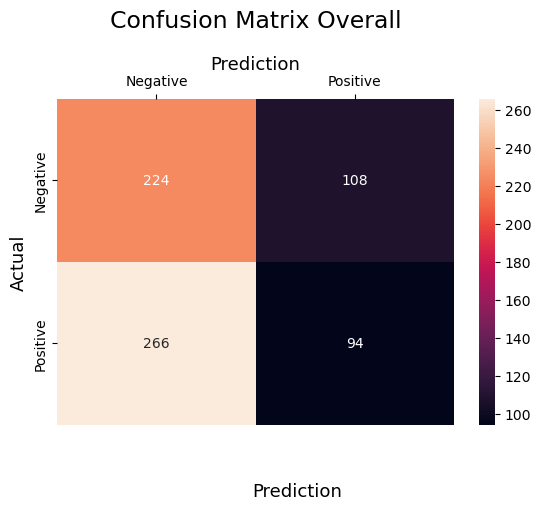

In [63]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

<mark>**iterations using quintiles 2> Taking Quintile 1,2 as Negative Progression flag and 3,4,5 as positive Progression flag**</mark>

In [64]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Derived_progression_quintile'] in [3,4,5] else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 66, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [65]:
classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 67, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.46      0.38      0.41       332
    Positive       0.50      0.59      0.54       360

    accuracy                           0.49       692
   macro avg       0.48      0.48      0.48       692
weighted avg       0.48      0.49      0.48       692



<mark>**confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations.**</mark>

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 68, Finished, Available, Finished)

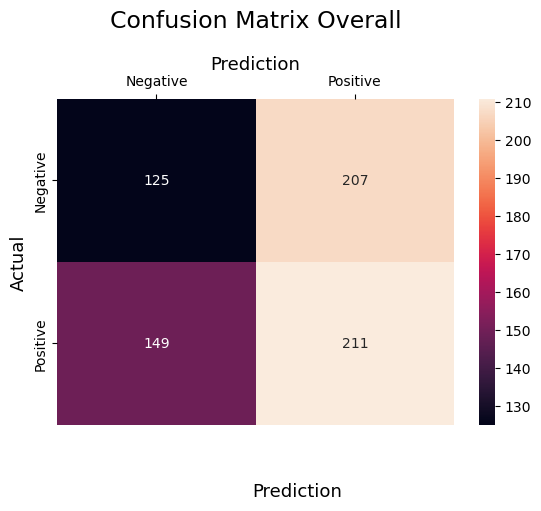

In [66]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

<mark>** **Finalised version Taking threshold Of positive Progression rate to be 0.7**</mark>**

In [67]:
joined_df['Predicted_Outcome'] = joined_df.apply(lambda row: "Positive" if row['Predicted_outcome_rate'] >0.7 else "Negative", axis=1)
joined_df = joined_df[['StudentNumber', 'IPLEVEL','Concatenated_column', 'Actual_Outcome','Predicted_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 69, Finished, Available, Finished)

<mark>**Classification report showing accuracy,precision,recall,f1 score**</mark>

In [68]:
classification_report = sklearn.metrics.classification_report(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 70, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.49      0.06      0.11       332
    Positive       0.52      0.94      0.67       360

    accuracy                           0.52       692
   macro avg       0.50      0.50      0.39       692
weighted avg       0.50      0.52      0.40       692



**<mark>confusion matrix where we get count of truly classified flags and wrongly classified flags. we try to increase the count of true classifications and reduce false classifications as much as possible by these threshold iterations. </mark>**

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 71, Finished, Available, Finished)

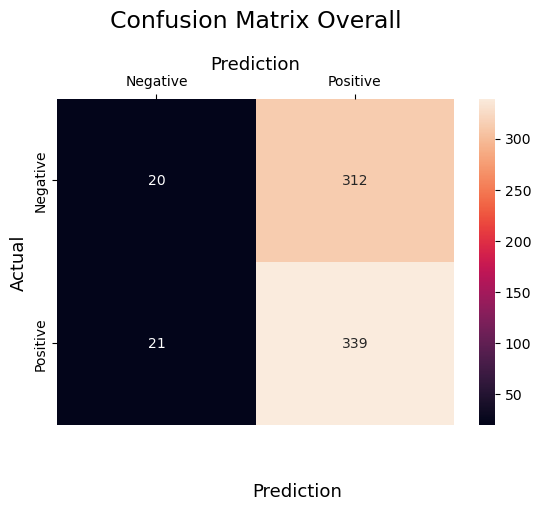

In [69]:
cm = sklearn.metrics.confusion_matrix(joined_df['Actual_Outcome'],joined_df['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix Overall', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [70]:
joined_df

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 72, Finished, Available, Finished)

,StudentNumber,IPLEVEL,Concatenated_column,Actual_Outcome,Predicted_Outcome,Predicted_outcome_rate,Derived_progression_quintile
0,STU62768,DEG,Quintile 321-25Cognitive or learning difficult...,Negative,Positive,0.710000,1
1,STU62566,DEG,Quintile 521-25Cognitive or learning difficult...,Positive,Positive,0.740000,1
2,STU56459,DEG,"Quintile 321-25Sensory, medical or physical im...",Positive,Positive,0.730000,1
3,STU56204,DEG,"Quintile 521-25Sensory, medical or physical im...",Negative,Negative,0.690000,1
4,STU66660,DEG,Quintile 121-25Mental health conditionWhiteQui...,Positive,Negative,0.590000,1
...,...,...,...,...,...,...,...
687,STU87073,DEG,Quintile 331-40No disability reportedWhiteQuin...,Positive,Positive,0.820000,3
688,STU70051,DEG,Quintile 431-40No disability reportedBlack or ...,Positive,Positive,0.820000,3
689,STU58231,DEG,Quintile 231-40No disability reportedWhiteQuin...,Positive,Positive,0.820000,3
690,STU56997,DEG,Quintile 131-40No disability reportedAsian or ...,Negative,Positive,0.820000,3


creating data to be used for model building to check feature importance plot

In [71]:
# final_output_df = pd.merge(concat_hist_char_export.drop('Outcome', axis=1), joined_df[['StudentNumber', 'IPLEVEL','Actual_Outcome', 'Predicted_Outcome', 'Predicted_outcome_rate', 'Derived_progression_quintile']], on=['StudentNumber', 'IPLEVEL'], how='inner')
# final_output_df

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 73, Finished, Available, Finished)

In [72]:
# filtered_df=final_output_df.copy()
# filtered_df.sort_values(by='Predicted_outcome_rate', ascending=True)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 74, Finished, Available, Finished)

In [73]:
# export_ft_df = pd.merge(joined_df,concat_hist_char_export,on='StudentNumber',how = 'inner')

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 75, Finished, Available, Finished)

In [74]:
# export_ft_df

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 76, Finished, Available, Finished)

In [75]:
# export_ft_df.columns

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 77, Finished, Available, Finished)

In [76]:
# export_ft_df = export_ft_df[[ 'StudentNumber', 'IPLEVEL_x',
#        'age_on_entry', 'ethnicity_16_groups', 'sex',
#        'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc',
#        'disability_type', 'IPSTARTMODE',
#        'Concatenated_column','Actual_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]
 
# export_ft_df.to_excel(f"{notebookutils.nbResPath}/builtin/FT_data_progression2.xlsx")

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 78, Finished, Available, Finished)

<mark>divide above df into 2 df based of iplevel</mark>

In [77]:
joined_df['IPLEVEL'].value_counts()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 79, Finished, Available, Finished)

IPLEVEL
DEG     690
PGTM      2
Name: count, dtype: int64

<mark>Filtering data for DEG level students and checking performances</mark>

In [78]:
joined_df_DEG = joined_df[joined_df['IPLEVEL']=='DEG']

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 80, Finished, Available, Finished)

In [79]:
joined_df_DEG.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 81, Finished, Available, Finished)

StudentNumber                   690
IPLEVEL                           1
Concatenated_column             504
Actual_Outcome                    2
Predicted_Outcome                 2
Predicted_outcome_rate           37
Derived_progression_quintile      5
dtype: int64

In [80]:
joined_df_DEG['Actual_Outcome'].value_counts()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 82, Finished, Available, Finished)

Actual_Outcome
Positive    359
Negative    331
Name: count, dtype: int64

In [82]:
joined_df_DEG['Predicted_Outcome'].value_counts()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 84, Finished, Available, Finished)

Predicted_Outcome
Positive    649
Negative     41
Name: count, dtype: int64

<mark>Filtering data for PGTM level students and checking performances</mark>

In [84]:
joined_df_PGTM = joined_df[joined_df['IPLEVEL']=='PGTM']

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 86, Finished, Available, Finished)

In [85]:
joined_df_PGTM.nunique()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 87, Finished, Available, Finished)

StudentNumber                   2
IPLEVEL                         1
Concatenated_column             2
Actual_Outcome                  2
Predicted_Outcome               1
Predicted_outcome_rate          2
Derived_progression_quintile    2
dtype: int64

In [86]:
joined_df_PGTM['Actual_Outcome'].value_counts()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 88, Finished, Available, Finished)

Actual_Outcome
Negative    1
Positive    1
Name: count, dtype: int64

In [87]:
joined_df_PGTM['Predicted_Outcome'].value_counts()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 89, Finished, Available, Finished)

Predicted_Outcome
Positive    2
Name: count, dtype: int64

<mark>performance</mark>

In [88]:
classes = ['Positive','Negative']

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 90, Finished, Available, Finished)

In [89]:
classification_report_DEG = sklearn.metrics.classification_report(joined_df_DEG['Actual_Outcome'],joined_df_DEG['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_DEG)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 91, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.49      0.06      0.11       331
    Positive       0.52      0.94      0.67       359

    accuracy                           0.52       690
   macro avg       0.50      0.50      0.39       690
weighted avg       0.50      0.52      0.40       690



In [90]:
classification_report_PGTM = sklearn.metrics.classification_report(joined_df_PGTM['Actual_Outcome'],joined_df_PGTM['Predicted_Outcome'],  digits=2, output_dict=False, zero_division=0)
print(classification_report_PGTM)

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 92, Finished, Available, Finished)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
    Positive       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 93, Finished, Available, Finished)

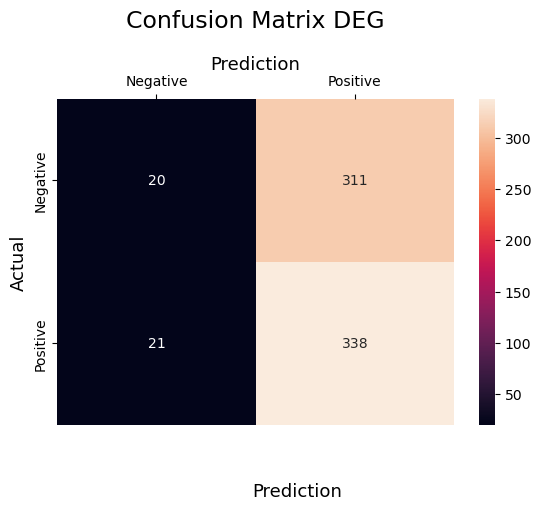

In [91]:
cm = sklearn.metrics.confusion_matrix(joined_df_DEG['Actual_Outcome'],joined_df_DEG['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix DEG', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

StatementMeta(, 110dcf6d-b012-42b9-83f8-e6d69bf914a5, 94, Finished, Available, Finished)

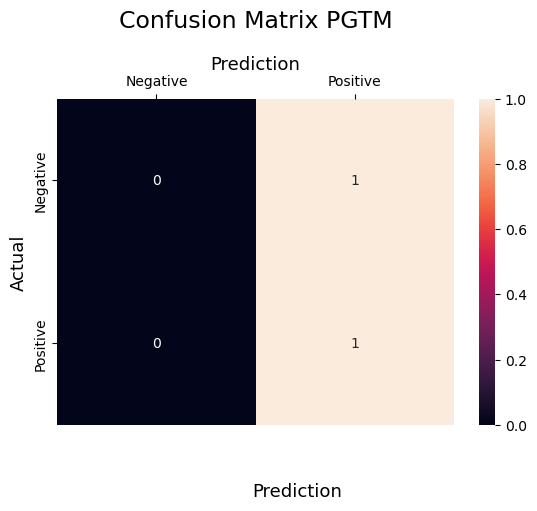

In [92]:
cm = sklearn.metrics.confusion_matrix(joined_df_PGTM['Actual_Outcome'],joined_df_PGTM['Predicted_Outcome'])
sns.heatmap(cm, 

            annot=True,

            fmt='g', 

            xticklabels=['Negative','Positive'],

            yticklabels=['Negative','Positive'])

plt.ylabel('Actual', fontsize=13)

plt.title('Confusion Matrix PGTM', fontsize=17, pad=20)

plt.gca().xaxis.set_label_position('top') 

plt.xlabel('Prediction', fontsize=13)

plt.gca().xaxis.tick_top()
 
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

 